# Bachelorarbeit
#### Nicolas Ebner, 2353610
Der Trade-off zwischen Effektivität und Differential Privacy bei Vorhersagemodellen mittels maschineller Lernverfahren: Eine Analyse anhand der Kreditwürdigkeitsprüfung im Finanzwesen.


# 3.3.1 EDA und Datenvorbereitung



In Folgenden Notebook wird der Prozess der explorativen Datenanalyse und der Datenvorbereitung durchgeführt.

## Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve,roc_auc_score, confusion_matrix, plot_confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Lese Daten ein

- Für diese Arbeit wird der Datensatz der Competition "Give Me Some Credit" von Kaggle.com verwendet.
- https://www.kaggle.com/c/GiveMeSomeCredit


- Es ist nur der Datensatz cs-training.csv relevant.
- cs-test.csv hat keine Ausprägung für die Zielvariable "SeriousDlqin2yrs" und wird lediglich für die Competiton auf Kaggle.com benötigt

In [2]:
df = pd.read_csv("input_data/cs-training.csv")
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## EDA
- Der Task ist eine binäre Klassifikation
- 150.000 Einträge und 10 Features (ohne Unnamed:0)
- Alle Werte sind nummerische (int, float)
    - Es muss kein Encoding gemacht werden
- In MonthlyIncome und NumberOfDependents gibt es null Werte

#### Entdeckte Outliers
- Age: Es gibt eine Spalte mit Alter 0
- Ungewöhnliche Werte bei NumberOfTime*DaysPastDueNotWorst
    - mit großem Abstand folgen die Ausprägungen (96, 98)
- Ungewöhnlich hohe Werte bei DebtRatio
    - 75% Quantil = 0,87  ->   Maximalwert = 329.644
    - Aus 35.137 Teilnehmer, die ein DebtRatio > 1 haben, haben nur 7.233 ein MonthlyIncome
- Ungewöhnlich hohe Werte bei RevolvingUtilizationOfUnsecuredLines
    - 75% Quantil = 0,58   ->   Maximalwert = 50.708
        
#### Bereinigung der Outlier.
- Die Outlier werden Schrittweise bereinigt.
    - Das als nächstes betrachtete Feature kann somit vom vorherigen beeinflusst werden
- Am Ende dieses Notebooks kann die Funktion preprocess_df() gefunden werden, welche alle Schritte der Datenvorbereitung beeinhaltet. 

#### Null Handling
- Zeilen mit leeren Feldern werden ebenfalls Schrittweise bearbeitet
    - Zeilen ohne Wert für MonthlyIncome werden entfernen
    - Leere Zeilen bei NumberOfDependets sind mit vorherigen Schritten automatisch gelöst
  
#### Conclusion
- weitere Änderungen an den Daten wie Skewness Ausgleich, Feature Engineering, Feature Selecting etc. wird nicht durchgeführt, damit Daten so original wie möglich bleiben
- Das Ziel ist es die Effektivität der DP Daten zu analysieren und nicht das beste Modell zu erstellen. 

#### Preprocessing Suggestions 
- folgt am Ende: es kann die Funktion preprocess_df() genutzt werden, um die Daten in einem Schritt vorzubereiten.

### Erste Untersuchungen auf den gesamten Datensatz

In [3]:
df.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

#### Unnamed: 0
- Die Spalte Unnamed: 0 wird entfernt, da sie keine Informationen über die Zielvariable enthält, sondern lediglich als ID Spalte fungiert.

In [6]:
df.drop("Unnamed: 0", axis=1, inplace=True, errors="ignore")

## Untersuchung der einzelnen Features und Visualisierung

#### SeriousDlqin2yrs
SeriousDlqin2yrs beschreibt, ob eine teilnehmende Person der Datenbank innerhalb der nächsten zwei Jahren eine schwerwiegende Delinquenz (Zahlungsverzug von mindestens 90 Tagen) aufweisen wird.

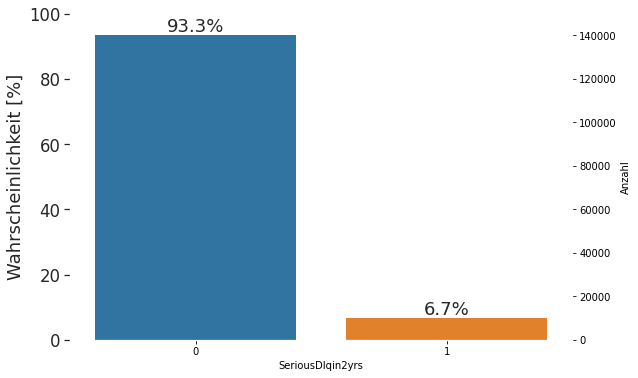

In [7]:
ax = sns.countplot(x = df.SeriousDlqin2yrs)
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
fig = plt.gcf()
fig.set_size_inches(9,6)

ncount = len(df)
ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Wahrscheinlichkeit [%]')
ax.set_ylabel("Anzahl")

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0,100)
ax2.grid(None)


# plt.tight_layout()
# plt.savefig('svg/default_comparison.svg')

plt.show()

In [8]:
df.corr()["SeriousDlqin2yrs"].abs().sort_values(ascending=False)

SeriousDlqin2yrs                        1.000000
NumberOfTime30-59DaysPastDueNotWorse    0.125587
NumberOfTimes90DaysLate                 0.117175
age                                     0.115386
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046048
NumberOfOpenCreditLinesAndLoans         0.029669
MonthlyIncome                           0.019746
DebtRatio                               0.007602
NumberRealEstateLoansOrLines            0.007038
RevolvingUtilizationOfUnsecuredLines    0.001802
Name: SeriousDlqin2yrs, dtype: float64

- Die Features haben keine besonders auffälligen Korrelationen mit der Zielvariablen

#### Age
Beschreibt das Alter der Teilnehmenden Person
- Durchschnittsalter bei 52.3 Jahren
- Jüngere Personen neigen eher dazu in Verzug zu geraten
> ein Ausreißer mit age=0 wird entfernt

<AxesSubplot:xlabel='SeriousDlqin2yrs', ylabel='age'>

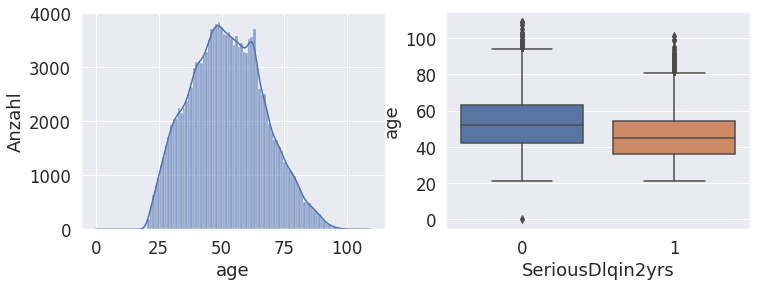

In [9]:
_, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].set_ylabel('Anzahl')

sns.histplot(df["age"], kde=True,stat='count',
             discrete=True, alpha=0.6, ax=axes[0])

sns.boxplot(x='SeriousDlqin2yrs', y="age", data=df, ax=axes[1])

# plt.tight_layout()
# plt.savefig('svg/distribution_age.svg')

- Es kann genau ein Outlier bei age = 0 erkannt werden

In [10]:
df[df["age"] < 18].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
25%,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
50%,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
75%,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0
max,0.0,1.0,0.0,1.0,0.436927,6000.0,6.0,0.0,2.0,0.0,2.0


- Dieser Eintrag wird ohne weitere Beachtung entfernt

In [11]:
# Entferne age kleiner 18
df = df[df["age"] > 18].copy()

#### Number Of Time Columns
Die drei Spalten NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse und NumberOfTimes90DaysLate sind in ihrer Bedeutung identisch und beschreiben die Anzahl der Fälle, in denen der Kreditnehmer in den letzten 2 Jahren mit der Zahlung überfällig war, sie unterscheiden sich lediglich in dem Zeitraum. 
- 99% Quantil bei allen im einstelligen Bereich.
- maximal Wert jeweils bei 98
- 269 Zeilen, bei denen Werte gleich mit 96 oder 98 gefüllt sind -> Zielvariable hier jedoch deutlich höher
> Zeilen mit Fehleinträgen werden mit Maximalwert der jeweiligen Spalte gefüllt

[ 0  1  2  3  4  5  6  7  8  9 11 96 98]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 96 98]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 96 98]


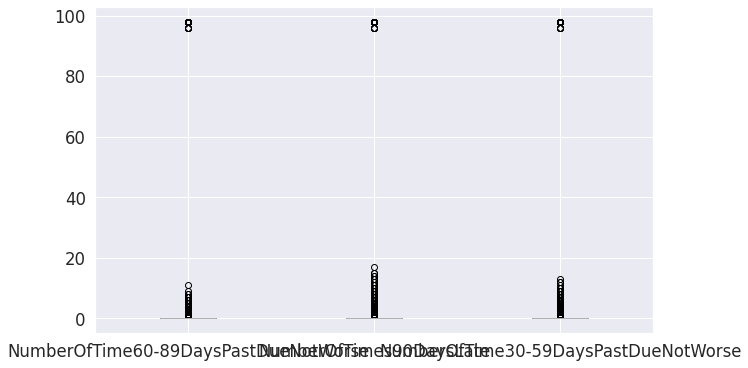

In [12]:
number_of_time3 = ["NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime30-59DaysPastDueNotWorse"]

print(np.unique(df[number_of_time3[0]]))
print(np.unique(df[number_of_time3[1]]))
print(np.unique(df[number_of_time3[2]]))

plt.figure(figsize=(10, 6)) 
df[number_of_time3].boxplot()
plt.show()

- Werden alle Ausprägungen der NumberOfTime Spalten ausgegeben, ist auffällig, dass es Ausreißer bei 96 und 98 gibt.

In [13]:
unregular_number_of_time = df[(df["NumberOfTime30-59DaysPastDueNotWorse"] > 50) | (df["NumberOfTime60-89DaysPastDueNotWorse"] > 50) | (df["NumberOfTimes90DaysLate"] > 50)]
unregular_number_of_time.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,269.000000,2.690000e+02,269.000000,269.000000,269.000000,148.000000,269.000000,269.000000,269.0,269.000000,238.000000
mean,0.546468,9.999999e-01,34.245353,97.962825,5.739667,2557.135135,0.007435,97.962825,0.0,97.962825,0.369748
std,0.498764,3.003190e-15,13.061823,0.270628,26.019024,2745.777653,0.086065,0.270628,0.0,0.270628,0.830490
min,0.000000,9.999999e-01,21.000000,96.000000,0.000000,0.000000,0.000000,96.000000,0.0,96.000000,0.000000
25%,0.000000,9.999999e-01,24.000000,98.000000,0.000000,1333.000000,0.000000,98.000000,0.0,98.000000,0.000000
50%,1.000000,9.999999e-01,29.000000,98.000000,0.000000,2168.500000,0.000000,98.000000,0.0,98.000000,0.000000
75%,1.000000,9.999999e-01,43.000000,98.000000,0.000000,3174.500000,0.000000,98.000000,0.0,98.000000,0.000000
max,1.000000,9.999999e-01,79.000000,98.000000,255.000000,28733.000000,1.000000,98.000000,0.0,98.000000,5.000000


- 269 Zeilen haben einen unregulären Wert in diesen Spalten
- Die Zielvariable hat einen deutlich höheren Wert als im Durchschnitt von 0.54
- Aus diesem Grund werden die Falsch eingetragenen Werte in diesen Spalten nicht als Nutzlos angesehen. 
- Sie werden mit dem höchsten Wert aus der jeweiligen Spalten der kleiner als 96 ist aufgefüllt

In [14]:
# Fülle die drei number of Time Spalten > 90 mit den jeweiligen maximum der Spalte
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] > 13, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] > 11, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
df.loc[df['NumberOfTimes90DaysLate'] > 17, 'NumberOfTimes90DaysLate'] = 17

#### DebtRatio & MonthlyIncome
DebtRatio beschreibt die monatlichen Schuldenzahlungen, Alimente und Lebenshaltungskosten geteilt durch das monatliche Bruttoeinkommen.
- Ein Wert von 1 bedeuted dementsprechend, dass sämtliche Ausgaben exakt dem Bruttoeinkommen entsprechen. 

MonthlyIncome beschreibt das monatliche Einkommen der Person

- Wenn DebtRatio > 1, dann haben die meisten Zeilen für MonthlyIncome keinen Wert
- Wenn MonthlyIncome == null, dann nimmt Debtratio zu 99% einen anormalen Prozentwert an
- Dieser Zusammenhang entsteht vermutlich, da DebtRatio von MonthlyIncome abhängig ist
> Die fehlerhaften Zeilen werden entfernt, da sie mehrere Spalten betreffen

In [15]:
df["DebtRatio"].describe()

count    149999.000000
mean        353.007426
std        2037.825113
min           0.000000
25%           0.175074
50%           0.366503
75%           0.868257
max      329664.000000
Name: DebtRatio, dtype: float64

- Da es sich bei DebtRatio um einen Prozentwert handelt, ist der Wert beim 75% Quantil mit 0,87 realisitisch.
- Der Maximalwert mit 329.664 erscheint jedoch nicht realisitisch


- Wie verhalten sich die Features bei einem unnormalen Prozentwert für DebtRatio von größer als 1?

In [16]:
df.query("DebtRatio > 1").describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,35137.000000,35137.000000,35137.000000,35137.000000,35137.000000,7233.000000,35137.000000,35137.000000,35137.000000,35137.000000,31689.000000
mean,0.065202,7.076243,55.006261,0.231551,1505.989566,2258.955067,8.071662,0.101432,1.082933,0.071065,0.436650
std,0.246885,239.510379,14.908925,0.769260,3999.026847,2831.168204,5.098427,0.684664,1.277702,0.458288,0.927896
min,0.000000,0.000000,21.000000,0.000000,1.000500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.022458,44.000000,0.000000,42.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.105250,55.000000,0.000000,907.000000,1577.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.490363,65.000000,0.000000,2210.000000,3333.000000,11.000000,0.000000,2.000000,0.000000,0.000000
max,1.000000,22198.000000,109.000000,13.000000,329664.000000,70000.000000,58.000000,17.000000,54.000000,11.000000,10.000000


- Von den 35.137 Einträgen mit einem DebtRatio von Größer als 1 haben nur 7.233 einen Wert für MonthlyIncome

- Wie sieht es umgekehrt betrachtet aus, welche Werte nimmt DebtRatio an, wenn MonthlyIncome null ist?

In [17]:
df[-(df.MonthlyIncome.notna())].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,29731.000000,29731.000000,29731.000000,29731.000000,29731.000000,0.0,29731.000000,29731.000000,29731.000000,29731.000000,25807.000000
mean,0.056137,6.649421,56.362349,0.233998,1673.396556,NaN,7.216071,0.155023,0.871481,0.098988,0.316310
std,0.230189,217.814854,15.438786,1.011921,4248.372895,NaN,4.842720,1.174635,1.034291,0.759283,0.809944
min,0.000000,0.000000,21.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.016027,46.000000,0.000000,123.000000,NaN,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.081697,57.000000,0.000000,1159.000000,NaN,6.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.440549,67.000000,0.000000,2382.000000,NaN,10.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,22198.000000,109.000000,13.000000,329664.000000,NaN,45.000000,17.000000,23.000000,11.000000,9.000000


- DebtRatio beschreibt ein Verhältnis und sollte normal im Durchschnitt zwischen 0 und 1 liegen.
- Bei den Spalten ohne MonthlyIncome weicht hier der Wert deutlich ab. 
- Das 50% Quantil liegt bei 1.159.


- Es stellt sich die Frage, wenn MonthlyIncome nicht bekannt, 0 oder 1 ist, wie viel Prozent der Einträge vom DebtRatio nehmen einen abnormalen Wert ein, der nicht zwischen 0 und 1 liegt?

In [18]:
# Datensatz mit allen Werten die für MonthlyIncome null, 0 oder 1 eingetragen haben
df_no_monthly_income = df[-(df["MonthlyIncome"].notna())].append(df.query("MonthlyIncome <= 1"))

# Datensatz mit den Einträgen, die für df_no_monthly_income einen Normalen Prozentsatz zwischen 0 und 1 haben
df_no_strange_values_for_debt_ratio = df_no_monthly_income.query("DebtRatio > 0 & DebtRatio < 1") 

# Anzahl von MonthlyIncomes mit null, 0 oder 1
count_no_monthly_income = df_no_monthly_income["SeriousDlqin2yrs"].count() # = 31970
# Anzahl von df_no_strange_values_for_debt_ratio
count_non_strange_debt_ratio = df_no_strange_values_for_debt_ratio["SeriousDlqin2yrs"].count() # = 3

print(f"{count_no_monthly_income / (count_no_monthly_income + count_non_strange_debt_ratio)} von DebtRatio hat einen abnormalen Wert wenn MonthlyIncome nicht bekannt ist.") 

0.9999061708316392 von DebtRatio hat einen abnormalen Wert wenn MonthlyIncome nicht bekannt ist.


> 99% der DebtRatios sind nicht zwischen 0 und 1, wenn MonthlyIncome nicht bekannt, 0 oder 1 ist.

- Wie sieht die Verteilung von DebtRatio zu MonthlyIncome Grafisch aus?
> DebtRatio nimmt nur für sehr niedrige MonthlyIncome anormale Werte an.


- Da Debtratio von MonthlyIncome abhängig ist, handelt es sich hier vermutlich, wenn kein MonthlyIncome bekannt ist, um den Schuldenstand und nicht um die Schuldenrate

<AxesSubplot:xlabel='DebtRatio', ylabel='MonthlyIncome'>

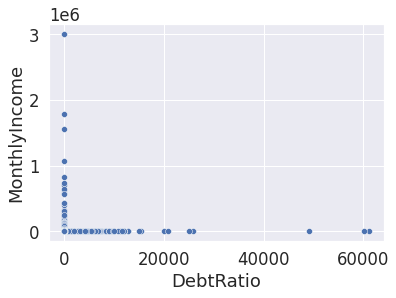

In [19]:
sns.scatterplot(x="DebtRatio", y="MonthlyIncome", data=df)

- Da DebtRatio von MonthlyIncome abhängig ist, handelt es sich hier vermutlich um den Schuldenstand und nicht um die Schuldenrate

In [20]:
df.query("DebtRatio > 10").describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,28877.000000,28877.000000,28877.000000,28877.000000,28877.000000,2106.000000,28877.000000,28877.000000,28877.000000,28877.000000,25725.000000
mean,0.055719,7.093624,55.292551,0.208124,1831.909066,118.451567,7.690134,0.101361,0.960488,0.067597,0.379553
std,0.229382,223.824910,14.726018,0.729173,4343.144572,962.739430,4.802446,0.688856,1.039328,0.452098,0.882985
min,0.000000,0.000000,21.000000,0.000000,10.138614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.022806,45.000000,0.000000,373.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.093737,56.000000,0.000000,1341.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.432984,65.000000,0.000000,2503.000000,1.000000,10.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,22198.000000,109.000000,13.000000,329664.000000,16500.000000,45.000000,17.000000,23.000000,11.000000,10.000000


> Ab einem DebtRatio von 10 steigen die Werte stark an
- Dabei tritt die Zielvariable im Durchschnitt sogar seltener Auf als im Bezug auf das gesamte Datenset. 
- Es sind somit ziemlich wahrscheinlich Fehleinträge.


- Da diese Einträge mehrere Spalten betreffen und die Zielvariable nicht häufiger auftritt als sonst, werden die falschen Einträge gelöscht.
- Dies beinhaltet:
    - Alle MonthlyIncome ohne Wert
    - Alle DebtRatios >= 10
    - Zeilen in denen DebtRatio und MonthlyIncome == 0

In [21]:
# Entferne Alle unmöglichen MonthlyIncome und DebtRatio
df = df[df['MonthlyIncome'].notna()]
df = df[df["DebtRatio"] < 10]
df = df[(df.DebtRatio != 0) | (df.MonthlyIncome != 0)]

In [22]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,118056.000000,118056.000000,118056.000000,118056.000000,118056.000000,1.180560e+05,118056.000000,118056.000000,118056.000000,118056.000000,118056.000000
mean,0.070009,5.940310,51.339220,0.278038,0.373736,6.793093e+03,8.780469,0.112218,1.058794,0.080750,0.852146
std,0.255164,258.845964,14.400315,0.844045,0.475565,1.449001e+04,5.176454,0.762286,1.152454,0.505455,1.147037
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035317,41.000000,0.000000,0.140760,3.500000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.178334,51.000000,0.000000,0.291056,5.474000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.580313,61.000000,0.000000,0.469740,8.330000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,50708.000000,103.000000,13.000000,9.906298,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


- Nach Bereinigung der Spalte MonthlyIncome, kann die Verteilung in Bezug zu der Zielvariable analysiert werden

(0.0, 20000.0)

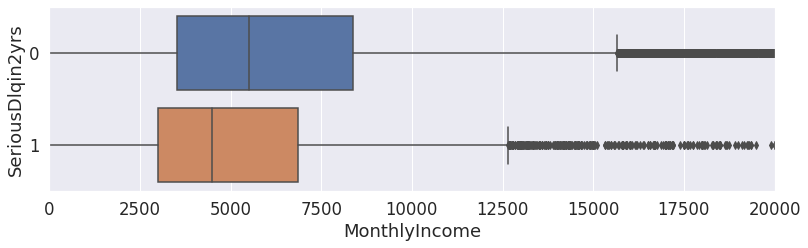

In [23]:
plt.figure(figsize=(13,4))
mi_boxplot = sns.boxplot(y="SeriousDlqin2yrs", x="MonthlyIncome", data=df, orient="h")
plt.gcf().subplots_adjust(bottom=0.24)

mi_boxplot.set_xlim(0, 20000)

# plt.savefig('svg/distribution_monthly_income.svg')

<AxesSubplot:xlabel='DebtRatio', ylabel='MonthlyIncome'>

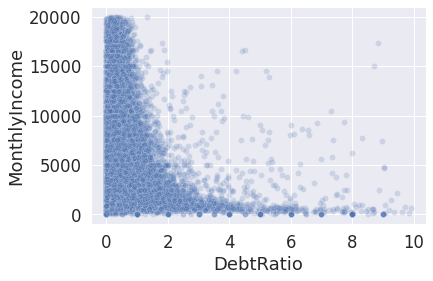

In [24]:
sns.scatterplot(x="DebtRatio", y="MonthlyIncome", data=df.query("MonthlyIncome < 20000"), alpha=0.2)

#### RevolvingUtilizationOfUnsecuredLines
Das Feature RevolvingUtilizationOfUnsecuredLines beschreibt das Gesamtsaldo von Kreditkarten und persönlichen Kreditlinien außer Immobilien und keine Ratenschulden wie Autokredite, geteilt durch die Summe der Kreditlimits. Es stellt also grundsätzlich das Verhältnis des geschuldeten Betrags zum Kreditlimit eines Kunden dar. 

- Der Wert für diese Spalte sollte somit ebenfalls in etwa zwischen 0 und 1 liegen
- 75% Quantil mit 0,58 erscheint normal, Maximalwert mit 50.708 deutlich zu hoch
- 170 Spalten mit RevolvingUtilizationOfUnsecuredLines > 10
- Zielvariable verhält sich ähnlich zu gesamten Datenset, lässt darauf schließen, dass es Fehleinträge sind
> Diese 170 Spalten werden entfernt

In [25]:
df["RevolvingUtilizationOfUnsecuredLines"].describe()

count    118056.000000
mean          5.940310
std         258.845964
min           0.000000
25%           0.035317
50%           0.178334
75%           0.580313
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

- Das 75% Quantil sieht realistisch aus.
- Der maximal Wert ist ungewöhnlich hoch. 


- Wie verhält sich RevolvingUtilizationOfUnsecuredLines > 10?

In [26]:
df.query("RevolvingUtilizationOfUnsecuredLines > 10").describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,0.088235,3893.539809,48.688235,0.235294,0.358410,8616.864706,6.152941,0.088235,1.300000,0.111765,0.894118
std,0.284475,5619.506800,13.217005,0.664342,0.341677,6523.852498,3.335326,0.651246,1.134974,0.656675,1.114971
min,0.000000,11.385230,25.000000,0.000000,0.000800,1280.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,958.250000,38.000000,0.000000,0.178164,4741.500000,4.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,2139.500000,46.000000,0.000000,0.277813,7041.500000,5.500000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4638.500000,58.000000,0.000000,0.433522,10178.750000,8.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,50708.000000,83.000000,3.000000,2.823035,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


- Diese Personen überziehen ihr Kreditlimit um das Zehnfach.
- Die Zielvariable steigt nicht deutlich an, es lässt darauf schließen, dass es sich um Fehleinträge handelt.


- Die 170 Werte mit einem RevolvingUtilizationOfUnsecuredLines von > 10 werden aus dem Datensatz entfernt.

In [27]:
df = df[df["RevolvingUtilizationOfUnsecuredLines"] < 10]

- Visualisiere RevolvingUtilizationOfUnsecuredLines

/home/bwlx/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='Density'>

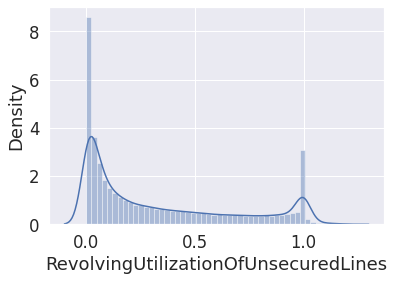

In [28]:
sns.distplot(df.query("RevolvingUtilizationOfUnsecuredLines < 1.2")["RevolvingUtilizationOfUnsecuredLines"])

(0.0, 4.0)

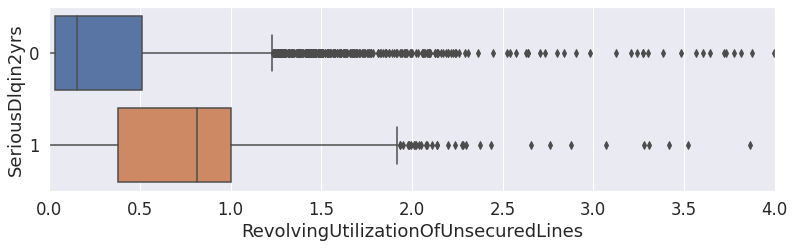

In [29]:
plt.figure(figsize=(13,4))
RUUL_boxplot = sns.boxplot(y="SeriousDlqin2yrs", x="RevolvingUtilizationOfUnsecuredLines", data=df, orient="h")
plt.gcf().subplots_adjust(bottom=0.24)

RUUL_boxplot.set_xlim(0, 4)

# plt.savefig('svg/distribution_RUUL.svg')

#### NumberOfDependents
Die Spalte NumberOfDependents beschreibt die Anzahl der unterhaltsberechtigten Personen in der Familie, ohne sich selbst.
- Die Spalte hatte zu Beginn 3.924 Einträge ohne Wert
- Diese sind durch vorherige Schritte bereits bereinigt
- Alle Werte erscheinen realistisch
> Es müssen keine Outlier verarbeitet werden

In [30]:
df.notna().count()

SeriousDlqin2yrs                        117886
RevolvingUtilizationOfUnsecuredLines    117886
age                                     117886
NumberOfTime30-59DaysPastDueNotWorse    117886
DebtRatio                               117886
MonthlyIncome                           117886
NumberOfOpenCreditLinesAndLoans         117886
NumberOfTimes90DaysLate                 117886
NumberRealEstateLoansOrLines            117886
NumberOfTime60-89DaysPastDueNotWorse    117886
NumberOfDependents                      117886
dtype: int64

- Alle Null Wert dieser Spalte wurden schon in vorschritten Bereinigt.

/home/bwlx/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Anzahl')

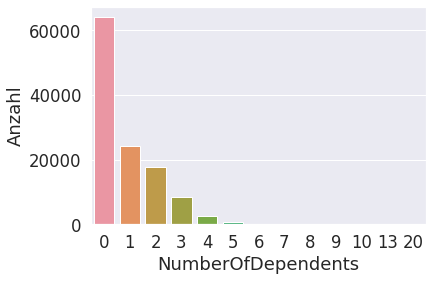

In [31]:
nod_countplot = sns.countplot(df["NumberOfDependents"].astype(int))
nod_countplot.set_ylabel("Anzahl")

In [32]:
df["NumberOfDependents"].value_counts()

0.0     64026
1.0     24092
2.0     17721
3.0      8540
4.0      2607
5.0       673
6.0       148
7.0        47
8.0        22
9.0         4
10.0        4
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64

- Alle Werte haben eine normale Ausprägung.
- Es müssen keine Ausreißer bereinigt werden


- Wie verhält sich NumberOfDependets zur Spalte age?

Text(0, 0.5, 'Ø NumberOfDependents')

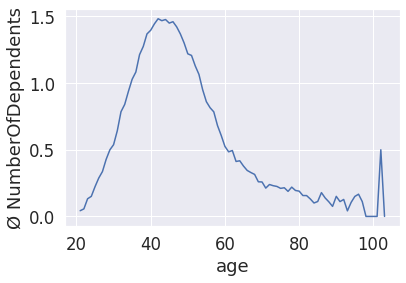

In [33]:
df_age_avg_dep = df.groupby("age")["NumberOfDependents"].mean()

age_dep_lineplot = sns.lineplot(x=df_age_avg_dep.index, y=df_age_avg_dep)

age_dep_lineplot.set_ylabel("Ø NumberOfDependents")

# plt.tight_layout()
# plt.savefig('svg/correlation_age_NOD.svg')

- Personen im mittelern Alter haben die höchste durchschnittliche Anzahl an NumberOfDependents


- Woher kommt der Ausreißer bei 102 Jahren?

In [34]:
df[df["age"] == 102]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
25561,0,0.009866,102,0,0.002424,3300.0,3,0,0,0,0.0
96450,0,0.109642,102,0,0.273844,3417.0,7,0,0,0,1.0


- Es gibt lediglich zwei Einträge im Alter von 102 Jahren, davon hat ein Eintrag bei NumberOfDependents den Wert 1
- Sprich der Durchschnitt liegt bei 0,5

- Wie verhält sich NumberOfDependents zu SeriousDlqin2yrs?

<AxesSubplot:xlabel='SeriousDlqin2yrs', ylabel='NumberOfDependents'>

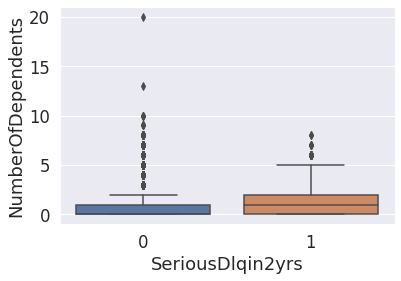

In [35]:
sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfDependents", data=df)

#### NumberOfOpenCreditLinesAndLoans und NumberRealEstateLoansOrLines
NumberOfOpenCreditLinesAndLoans und NumberRealEstateLoansOrLines - Erstere beschreibt laut der Spaltenbeschreibung in Kaggle.com die Anzahl an offenen Krediten z. B. Ratenzahlungen wie Autokredite oder Hypotheken und offenen Kreditlinien wie z. B. Kreditkarten. Zweitere beinhaltet die Anzahl der Hypotheken- und Immobilienkredite einschließlich Home-Equity-Kreditlinien.
- Hypotheken wären nach der Spaltenbeschreibung in beiden Spalten vertreten
- Nach Spaltenbezeichnung eher nur in "NumberRealEstateLoansOrLines"
- Alle Spalten nehmen einen normalen Wert an.
> Es müssen keine Outlier bereiningt werden

In [36]:
number_of_lines = ["NumberOfOpenCreditLinesAndLoans", "NumberRealEstateLoansOrLines"]

df[number_of_lines].describe()

,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines
count,117886.000000,117886.000000
mean,8.784258,1.058446
std,5.177683,1.152448
min,0.000000,0.000000
25%,5.000000,0.000000
50%,8.000000,1.000000
75%,11.000000,2.000000
max,58.000000,54.000000


- Alle Spalten nehmen normalen Wert an.
- Es müssen keine Ausreißer verarbeitet werden.

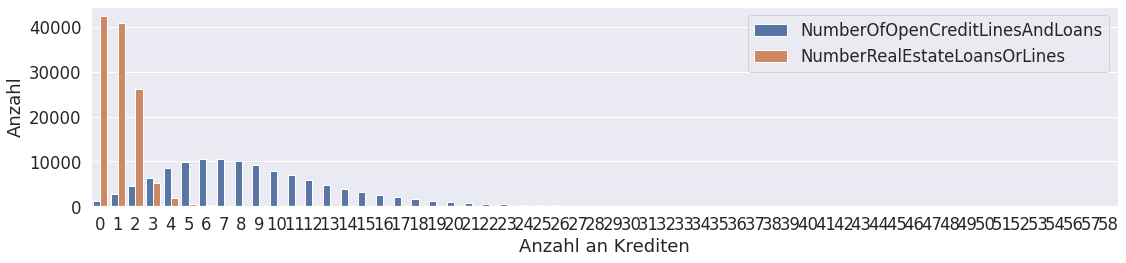

In [37]:
two_colums = df[number_of_lines]

plt.figure(figsize=(16,4))
numberof_countplot = sns.countplot(x="value", hue="variable", data=pd.melt(two_colums))
numberof_countplot.set_ylabel("Anzahl")
numberof_countplot.set_xlabel("Anzahl an Krediten")
plt.legend(loc='upper right')
plt.tight_layout()

# plt.savefig("svg/number_of_credits.svg")

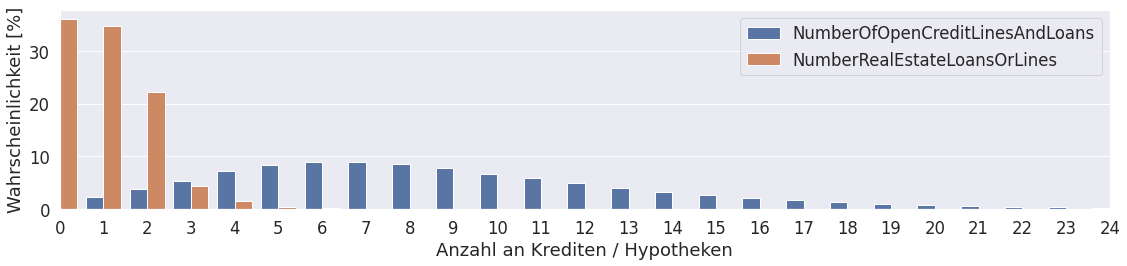

In [38]:
two_colums = df[number_of_lines]

plt.figure(figsize=(16,4))
numberof_countplot = sns.barplot(x="value", y="value", hue="variable", data=pd.melt(two_colums), estimator=lambda value: len(value) / len(df) * 100)
numberof_countplot.set_ylabel("Wahrscheinlichkeit [%]")
numberof_countplot.set_xlabel("Anzahl an Krediten / Hypotheken")
numberof_countplot.set_xlim(0, 24)

plt.legend(loc='upper right')
plt.tight_layout()

# plt.savefig("svg/number_of_credits.svg")

#### Hiermit sind alle Spalten einmal gesondert Betrachtet worden 
- es wurden alle gefunden Ausreißer und Null Spalten verarbeitet

#### Korrelationen auf bereiningten Datensatz

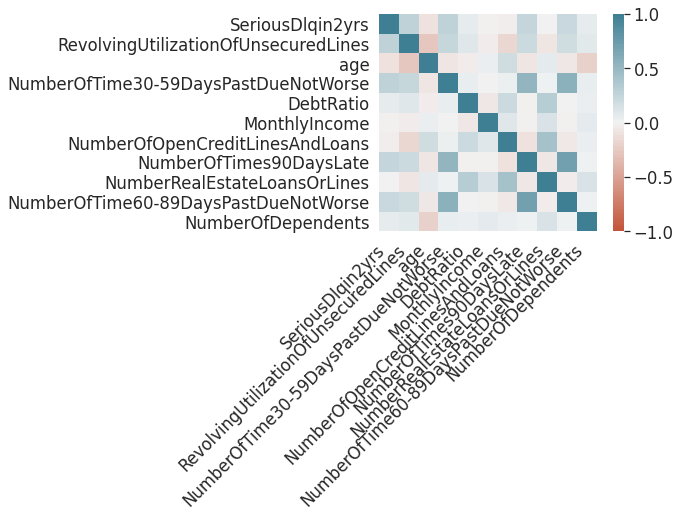

In [39]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

- Die höchste Korrelationen haben die NumberOfTimes Spalten zu der Zielvariablen
- Die Korrelationen sind jedoch nicht besonders Stark. 

In [40]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,117886.000000,117886.000000,117886.000000,117886.000000,117886.000000,1.178860e+05,117886.000000,117886.000000,117886.000000,117886.000000,117886.000000
mean,0.069983,0.334115,51.343043,0.278099,0.373759,6.790463e+03,8.784258,0.112253,1.058446,0.080705,0.852086
std,0.255119,0.363905,14.401650,0.844277,0.475732,1.449818e+04,5.177683,0.762436,1.152448,0.505206,1.147086
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035213,41.000000,0.000000,0.140747,3.500000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.177562,51.000000,0.000000,0.291068,5.470000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.577706,61.000000,0.000000,0.469776,8.324750e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,8.851852,103.000000,13.000000,9.906298,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


## Datenvorbereitung

In [41]:
 def preprocess_df(table):
    """This function takes a full GiveMeSomeCredit Dataset and preprocess all steps which are made for this Thesis.
    It Returns the Preprocessed Dataset.
    """
    # Entferne ID Spalte ("Unnamed: 0")
    table.drop("Unnamed: 0", axis=1, inplace=True, errors="ignore")
        
    # Entferne age kleiner 18
    table = table[table["age"] > 18].copy()

    # Fülle die drei number of Time Spalten > 90 mit den jeweiligen maximum der Spalte
    table.loc[table['NumberOfTime30-59DaysPastDueNotWorse'] > 13, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
    table.loc[table['NumberOfTime60-89DaysPastDueNotWorse'] > 11, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
    table.loc[table['NumberOfTimes90DaysLate'] > 17, 'NumberOfTimes90DaysLate'] = 17

    # Entferne Alle unmöglichen MonthlyIncome und DebtRatio
    table = table[table['MonthlyIncome'].notna()]
    table = table[table["DebtRatio"] < 10]
    table = table[(table.DebtRatio != 0) | (table.MonthlyIncome != 0)]

    # Entferne RUUL Größer 10
    table = table[table['RevolvingUtilizationOfUnsecuredLines'] < 10]
    
    return table

## Datenset erstellen

- Es hat sich gezeigt, dass die besten Ergebnisse des DP-WGAN mit einem Standardskalierten Datenset erreicht werden
- Also wird hier das Datenset einmal normal und einmal Skaliert exportiert

In [42]:
def xy_split(table:pd.DataFrame):
    """Takes a full Give Me some Credit Dataset
        Returns X, y splitted Dataset
    """
    table.drop("Unnamed: 0", axis=1, errors="ignore", inplace=True)
    y = table[["SeriousDlqin2yrs"]]
    y.reset_index(drop=True, inplace=True)
    X = table.drop("SeriousDlqin2yrs", axis=1)
    X.reset_index(drop=True, inplace=True)
    return X, y

def scaleX(table_X: pd.DataFrame) -> pd.DataFrame:
    """StandardScales the X values of a DataFrame.
    Do not include Targetvariable, as it would also Scale it
    """
    scaler = preprocessing.StandardScaler()
    scaled = scaler.fit_transform(table_X)
    return pd.DataFrame(data=scaled, columns=table_X.columns).copy()

def scaleTable(table: pd.DataFrame) -> pd.DataFrame:
    """This Function StandardScales a whole Dataset.
    It should also contain Targetvariable
    """
    X, y = xy_split(table)
    X = scaleX(X)
    result=pd.concat([y, X], axis=1)
    return result

In [43]:
# df.to_csv("./output_data/processed_dataset.csv")

data_train, data_test = train_test_split(df, test_size=0.25, random_state=42)

# data_train.to_csv('./output_data/full_train_processed.csv', index=False)
# data_test.to_csv('./output_data/full_test_processed.csv', index=False)


df_scaled = scaleTable(df)
data_train_scaled, data_test_scaled = train_test_split(df_scaled, test_size=0.25, random_state=42)
# data_train_scaled.to_csv('./output_data/full_train_processed_scaled.csv', index=False)
# data_test_scaled.to_csv('./output_data/full_test_processed_scaled.csv', index=False)

In [44]:
df_scaled.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1.187161,-0.440441,2.039507,0.902243,0.160679,0.814218,-0.147229,4.287895,-0.159748,1.000726
1,0,1.712093,-0.787624,-0.329395,-0.529465,-0.289035,-0.924019,-0.147229,-0.918437,-0.159748,0.128948
2,0,0.890526,-0.926498,0.855056,-0.606742,-0.258548,-1.310294,1.164362,-0.918437,-0.159748,-0.742830
3,0,-0.275636,-1.481992,-0.329395,-0.709876,-0.240753,-0.730882,-0.147229,-0.918437,-0.159748,-0.742830
4,0,1.574937,-0.162693,0.855056,-0.733259,3.917579,-0.344607,-0.147229,-0.050715,-0.159748,-0.742830


In [45]:
data_train_scaled.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000,88414.000000
mean,0.070045,0.000699,0.002083,-0.000802,-0.001054,0.000251,0.001198,-0.001004,0.000771,-0.000413,-0.001571
std,0.255225,1.003366,0.999401,0.993528,0.990470,1.073057,0.999892,0.985864,0.997020,0.989002,0.999363
min,0.000000,-0.918141,-2.106923,-0.329395,-0.785653,-0.468369,-1.696569,-0.147229,-0.918437,-0.159748,-0.742830
25%,0.000000,-0.821025,-0.718188,-0.329395,-0.490562,-0.226958,-0.730882,-0.147229,-0.918437,-0.159748,-0.742830
50%,0.000000,-0.429108,-0.023820,-0.329395,-0.173016,-0.091768,-0.151469,-0.147229,-0.050715,-0.159748,-0.742830
75%,0.000000,0.667675,0.739985,-0.329395,0.203062,0.104654,0.427943,-0.147229,0.817007,-0.159748,1.000726
max,1.000000,23.406585,3.586893,15.068466,20.037727,207.058533,9.505401,22.149820,45.938548,21.613635,16.692729
